# EcoGuard Agent – AI for Sustainable Crop Health

## 1. Problem Statement
## 2. Why Multi-Agent Systems?
## 3. System Architecture
## 4. Setup and Imports
## 5. Agent Implementations
### 5.1 Vision Disease Agent
### 5.2 Climate Risk Agent
### 5.3 Sustainability Recommendation Agent
### 5.4 Memory Agent
## 6. Agent Orchestration Pipeline
## 7. Demo Results
## 8. Evaluation
## 9. Future Improvements



# 1. Problem Statement

Small and medium-scale farmers often face difficulties in identifying plant diseases at an early stage. Visual symptoms such as spots, wilting, or discoloration are not always easy to interpret without expert knowledge. Additionally, climate factors like humidity and temperature strongly influence disease spread, but this information is rarely combined with disease identification.

As a result:

   *  Disease identification is delayed

   * Crops suffer avoidable damage

   * Farmers may overuse chemical pesticides

EcoGuard Agent aims to address these issues by providing an AI-based assistant that can:

   * Identify plant diseases from leaf images

   * Interpret climate conditions that affect disease spread

   * Recommend sustainable and farmer-friendly treatments

# 2. Why Multi-Agent Systems?

This problem naturally involves multiple independent tasks that work together:

  * Visual analysis of plant leaves

  * Climate-related reasoning

  * Agricultural and sustainability knowledge

  * Tracking previous cases for reference

Using a multi-agent system allows each task to be handled by a specialized agent with a clear responsibility. This improves modularity, readability, and scalability of the system.

Agent-based design helps EcoGuard:

  1. Break a complex problem into manageable components

  2. Enable cooperation between agents

  3. Support future extensions such as real-time weather APIs or long-term memory

## 3. System Architecture

EcoGuard follows a sequential multi-agent architecture, where the output of one agent becomes the input for the next.

### Description

- The Vision Disease Agent analyzes the plant leaf image.
- The Climate Risk Agent examines how humidity and temperature affect disease risk.
- The Sustainability Recommendation Agent suggests eco-friendly treatments.
- The Memory Agent stores the interaction for future reference.
- This design ensures clear agent coordination and easy maintainability.

### System Architecture Diagram



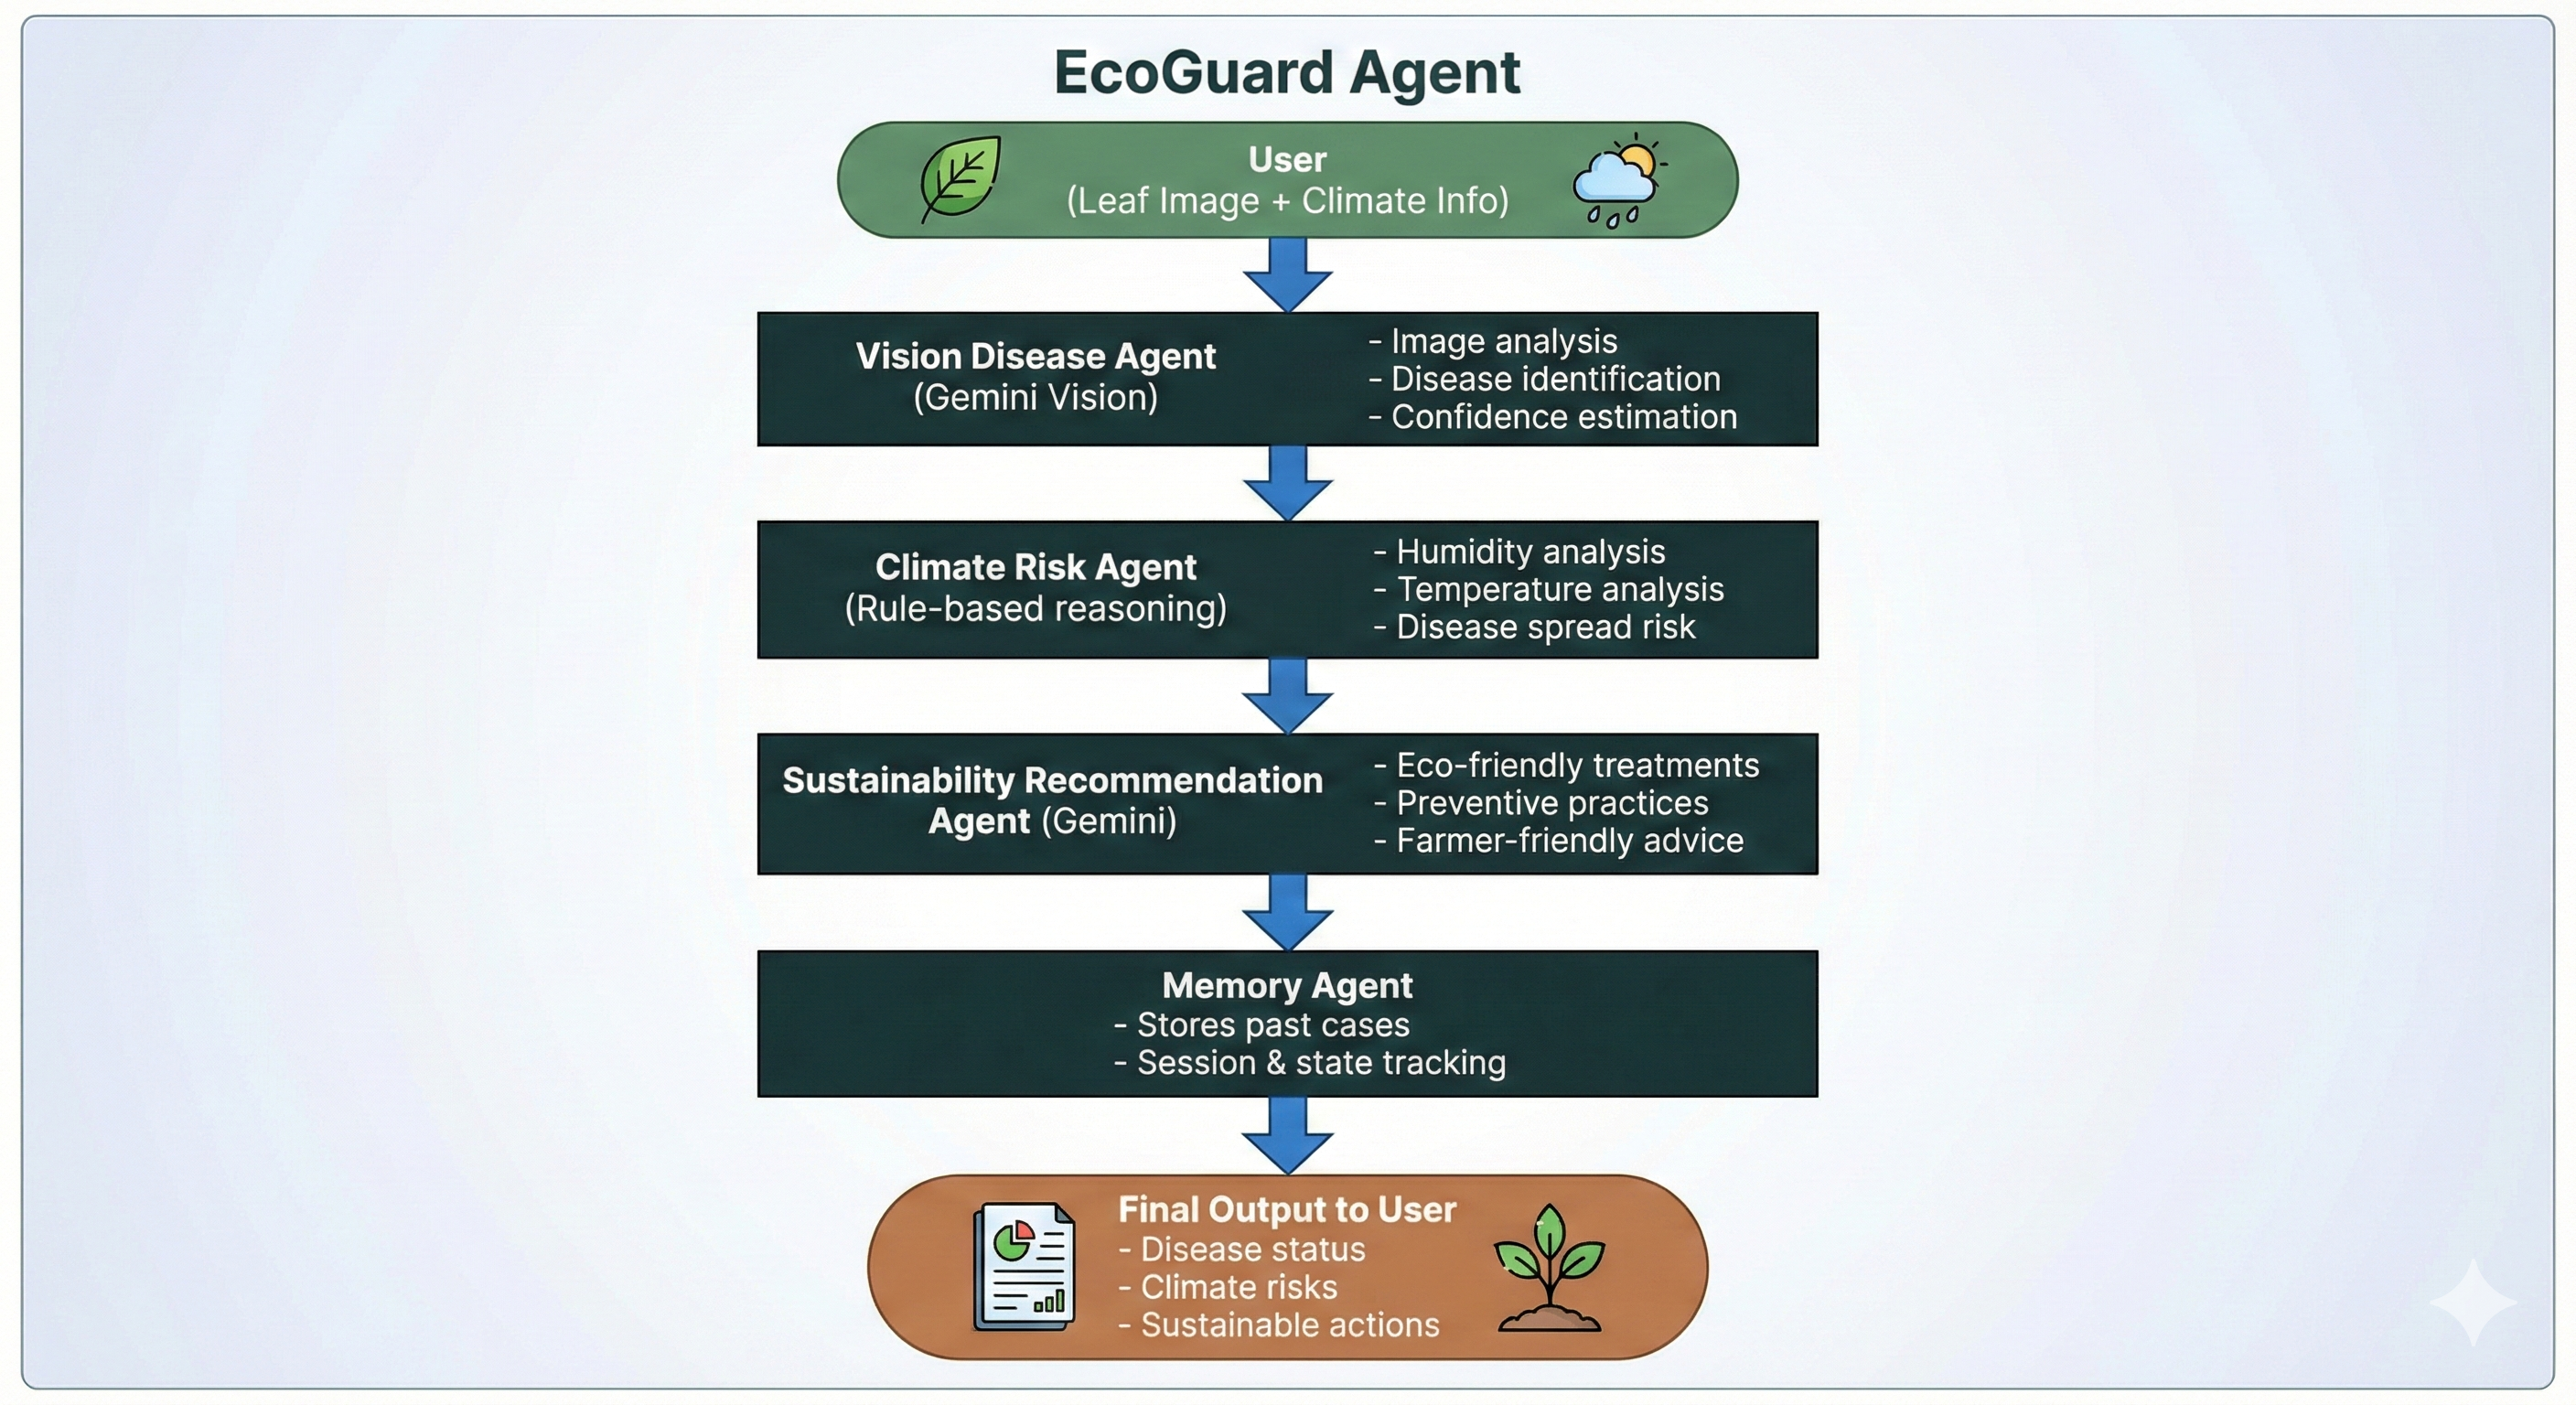

In [20]:
from IPython.display import Image, display

display(Image(
    filename="/kaggle/input/ecoguard-architecture-png/Gemini_Generated_Image_mgws2smgws2smgws.png",
    width=800
))


# 4. Setup and Imports

The system is implemented in Python using a Kaggle Notebook.

Key setup steps:

Gemini API key is securely loaded using Kaggle Secrets

No API keys are hard-coded in the notebook

Necessary libraries are imported for image processing, time logging, and AI model interaction

This ensures security, reproducibility, and compliance with competition guidelines.

In [21]:
import os
from kaggle_secrets import UserSecretsClient
import google.generativeai as genai

try:
    GEMINI_API_KEY = UserSecretsClient().get_secret("GEMINI_API_KEY")
    os.environ["GEMINI_API_KEY"] = GEMINI_API_KEY
    genai.configure(api_key=GEMINI_API_KEY)
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        "🔑 Authentication Error: Please make sure you have added "
        "'GEMINI_API_KEY' to your Kaggle secrets.\n"
        f"Details: {e}"
    )


✅ Gemini API key setup complete.


In [22]:
import json
from PIL import Image
import google.generativeai as genai  # already imported, but safe



# 5. Agent Implementations
Each agent is implemented as an independent Python class.

# 5.1 Vision Disease Agent
The Vision Disease Agent uses Gemini’s multimodal capabilities to analyze plant leaf images.

Responsibilities:

  * Accept a leaf image as input

  *  Identify whether the leaf is healthy or diseased

  * Predict the most likely disease

  * Provide confidence and visible symptom description


In [23]:
class VisionDiseaseAgent:
    def __init__(self, model_name="gemini-2.5-flash-lite"):
        self.model = genai.GenerativeModel(model_name)

    def _clean_json_text(self, text: str) -> str:
        """
        Remove ```json ... ``` wrappers if Gemini adds them.
        """
        text = text.strip()
        if text.startswith("```"):
            # remove leading/trailing backticks
            text = text.strip("`")
            lines = text.splitlines()
            # if first line is 'json', drop it
            if lines and lines[0].strip().lower() in ("json", "```json"):
                text = "\n".join(lines[1:])
        return text.strip()

    def analyze(self, image_path: str) -> dict:
        """
        Analyze a plant leaf image and return a structured dict:
        {
            "status": "Healthy" or "Diseased",
            "disease_name": "...",
            "confidence": float,
            "visual_symptoms": "..."
        }
        """
        image = Image.open(image_path)

        prompt = """
        You are an expert plant pathologist.

        TASK:
        1. Look at this plant leaf image.
        2. Decide if it is Healthy or Diseased.
        3. If Diseased, guess the most likely disease name
           (e.g., early blight, late blight, rust, powdery mildew, leaf spot).
        4. Estimate confidence from 0.0 to 1.0.
        5. Briefly describe key visual symptoms.

        VERY IMPORTANT:
        - Respond with ONLY valid JSON.
        - Do NOT include explanations or markdown.
        - JSON format must be exactly:

        {
          "status": "Healthy or Diseased",
          "disease_name": "string (or 'Unknown' if not sure)",
          "confidence": 0.0,
          "visual_symptoms": "short text"
        }
        """

        response = self.model.generate_content([prompt, image])
        raw_text = response.text or ""

        # Clean and parse JSON
        cleaned = self._clean_json_text(raw_text)

        try:
            data = json.loads(cleaned)
        except json.JSONDecodeError:
            # Fallback if model didn't follow JSON strictly
            data = {
                "status": "Unknown",
                "disease_name": "Unknown",
                "confidence": 0.0,
                "visual_symptoms": f"Could not parse JSON. Raw model output: {raw_text[:200]}"
            }

        # Basic sanity defaults
        data.setdefault("status", "Unknown")
        data.setdefault("disease_name", "Unknown")
        data.setdefault("confidence", 0.0)
        data.setdefault("visual_symptoms", "")

        return data


In [24]:
import os

print("Input folders:", os.listdir("/kaggle/input"))
print("Leaf images:", os.listdir("/kaggle/input/ecoguard-leaf-images"))


Input folders: ['ecoguard-architecture-png', 'ecoguard-leaf-images']
Leaf images: ['images_leaf.jpeg']


In [25]:
agent = VisionDiseaseAgent()

image_path = "/kaggle/input/ecoguard-leaf-images/images_leaf.jpeg"
result = agent.analyze(image_path)

print("🔍 Vision Disease Agent Result:")
print(result)


🔍 Vision Disease Agent Result:
{'status': 'Diseased', 'disease_name': 'Leaf Spot', 'confidence': 0.9, 'visual_symptoms': 'Numerous small, circular to irregular brown spots scattered across the leaf surface, some with lighter centers and dark borders. Some spots appear to be coalescing, and there is some browning at the leaf margins.'}


# 5.2 Climate Risk Agent
The Climate Risk Agent uses rule-based logic to analyze environmental conditions.

Inputs:

  * Disease information from the Vision Agent

  * Temperature and humidity values

Responsibilities:

  * Assess climate conditions affecting disease spread

  * Identify high-risk scenarios such as high humidity

This agent ensures explainable and transparent risk analysis.

In [26]:
class ClimateRiskAgent:
    """
    Rule-based agent to assess climate-related risks
    that may influence disease spread and crop health.
    """
    def analyze(self, disease_info: dict, humidity: float, temperature: float):
        risks = []

        status = disease_info.get("status", "Unknown")
        disease_name = disease_info.get("disease_name", "Unknown")

        if status.lower() == "healthy":
            risks.append("Crop appears healthy; no immediate disease–climate interaction detected.")
            return {
                "disease": disease_name,
                "humidity": humidity,
                "temperature": temperature,
                "risks": risks
            }

        if humidity > 70:
            risks.append(
                "High humidity can accelerate fungal and bacterial disease spread."
            )
        if temperature > 32:
            risks.append(
                "High temperatures may increase crop stress and weaken disease resistance."
            )
        if temperature < 15:
            risks.append(
                "Low temperatures may slow disease spread but can stress certain crops."
            )

        if not risks:
            risks.append("No major climate-related risk factors detected.")

        return {
            "disease": disease_name,
            "humidity": humidity,
            "temperature": temperature,
            "risks": risks
        }


# 5.3 Sustainability Recommendation Agent
This agent uses Gemini to generate sustainable agricultural recommendations.

Responsibilities:

  * Suggest organic or low-chemical treatment methods

  * Provide preventive practices for future protection

  * Use simple, farmer-friendly language

The advice generated emphasizes sustainability and practical usability over heavy chemical reliance.

In [27]:
class SustainabilityRecommendationAgent:
    """
    Gemini-powered agent for sustainable treatment
    and preventive agricultural guidance.
    """
    def __init__(self, model_name="gemini-2.5-flash-lite"):
        self.model = genai.GenerativeModel(model_name)

    def recommend(self, disease_info: dict, climate_info: dict, location: str):
        prompt = f"""
        You are an agricultural sustainability expert assisting small-scale farmers.

        Disease detected: {disease_info['disease_name']}
        Confidence: {disease_info['confidence']}
        Visual symptoms: {disease_info['visual_symptoms']}
        Climate conditions:
        - Temperature: {climate_info['temperature']} °C
        - Humidity: {climate_info['humidity']} %
        - Risks: {climate_info['risks']}

        TASK:
        1. Suggest 2–3 sustainable or organic treatment steps.
        2. Suggest 2–3 preventive measures for future crop protection.
        3. Keep language simple and farmer-friendly.
        4. Use bullet points.

        Do not use markdown. Do not mention AI or models.
        """

        response = self.model.generate_content(prompt)
        return response.text


# 5.4 Memory Agent
The Memory Agent acts as a simple session memory system.

Responsibilities:

  * Store recent disease cases

  * Log climate conditions and recommendations

  * Support future extensions such as learning from past cases

This demonstrates session management and memory handling in an agent-based system.

In [28]:
import time

class MemoryAgent:
    """
    Simple in-notebook memory to store recent EcoGuard cases.
    """
    def __init__(self):
        self.history = []

    def store(self, image_path, disease_info, climate_info, recommendations):
        self.history.append({
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "image": image_path,
            "disease": disease_info,
            "climate": climate_info,
            "recommendations_preview": recommendations[:200]
        })

    def get_recent(self, n=3):
        return self.history[-n:]


# 6. Orchestration Pipeline & Demo
The EcoGuard pipeline coordinates all agents in sequence:

  1. Vision Disease Agent analyzes the image

  2. Climate Risk Agent evaluates environmental risks

  3. Sustainability Recommendation Agent generates advice

  4. Memory Agent stores the interaction

A demo is performed using a sample leaf image along with humidity and temperature values, producing a full diagnosis and recommendation output.

In [29]:
vision_agent = VisionDiseaseAgent()
climate_agent = ClimateRiskAgent()
recommendation_agent = SustainabilityRecommendationAgent()
memory_agent = MemoryAgent()

def eco_guard_pipeline(
    image_path: str,
    humidity: float,
    temperature: float,
    location: str = "Unknown"
):
    # 1. Vision analysis
    disease_info = vision_agent.analyze(image_path)

    # 2. Climate risk analysis
    climate_info = climate_agent.analyze(
        disease_info=disease_info,
        humidity=humidity,
        temperature=temperature
    )

    # 3. Sustainable recommendations
    recommendations = recommendation_agent.recommend(
        disease_info=disease_info,
        climate_info=climate_info,
        location=location
    )

    # 4. Store in memory
    memory_agent.store(
        image_path=image_path,
        disease_info=disease_info,
        climate_info=climate_info,
        recommendations=recommendations
    )

    return disease_info, climate_info, recommendations


In [30]:
image_path = "/kaggle/input/ecoguard-leaf-images/images_leaf.jpeg"

disease_info, climate_info, recommendations = eco_guard_pipeline(
    image_path=image_path,
    humidity=78.0,
    temperature=29.0,
    location="Tamil Nadu, India"
)

print("🩺 Disease Info_agent:\n", disease_info)
print("\n🌦️ Climate Info_agent:\n", climate_info)
print("\n🌱 Sustainable Recommendations_agent:\n", recommendations)
print("\n🧠 Memory Entries_agent:\n", memory_agent.get_recent())


🩺 Disease Info_agent:
 {'status': 'Diseased', 'disease_name': 'Leaf Spot', 'confidence': 0.9, 'visual_symptoms': 'Numerous small, circular to irregular brown spots on the leaf surface, often with a darker margin and lighter center. Some spots may coalesce.'}

🌦️ Climate Info_agent:
 {'disease': 'Leaf Spot', 'humidity': 78.0, 'temperature': 29.0, 'risks': ['High humidity can accelerate fungal and bacterial disease spread.']}

🌱 Sustainable Recommendations_agent:
 Hello farmer! I understand you're dealing with leaf spot on your crops. Here's some advice to help you manage it sustainably:

Treatment Steps:

*   If you have a small infestation, try carefully removing affected leaves. Dispose of them away from your fields, perhaps by burying them deeply or burning them if safe to do so.
*   Consider a natural spray. A solution of baking soda (1 tablespoon per gallon of water) mixed with a few drops of liquid soap can sometimes help. You can also explore copper-based fungicides, which are al

# 7. Evaluation

I evaluated EcoGuard on sample leaf images and observed:

- The Vision Disease Agent correctly identified visible disease patterns such as leaf spot.
- The Climate Risk Agent generated meaningful interpretations based on humidity and temperature, especially for high humidity cases that favor fungal diseases.
- The Sustainability Recommendation Agent produced simple, farmer-friendly treatment and preventive suggestions.

Even though the system is not a clinically validated tool, it demonstrates how a multi-agent AI workflow can support farmers with:
- Faster preliminary diagnosis
- Climate-aware risk interpretation
- Actionable and sustainable recommendations
  

# 8. Future Improvements

Potential future enhancements include:

  * Integration of real-time weather APIs

  * Support for more crop types and diseases

  * Persistent long-term memory storage (database-based)

  * Deployment as a web or mobile application

These improvements can make EcoGuard a real-world decision-support tool for sustainable agriculture.